In [47]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pymc3 as pm
import theano.tensor as tt
matplotlib.style.use("ggplot")
%matplotlib inline


# Aufgabe

Ein Kunde hat zahlreiche baugleiche Maschinen im Feld. Diese wurden zu unterschiedlichen Zeiten in Betrieb genommen. Maschinenausfall wird über das zentrale Servicemanagement zurückgemeldet. 
Nachdem nun bereits die ersten Maschinen ausgefallen sind, möchte der Kunde gerne eine Prognose für die Anzahl zukünftiger Maschinenausfälle ableiten, um seine Service-Mitarbeiter zu planen.

## 1)
Nutze Pymc um die Posterior Verteilung der Parameter einer Weibullverteilung für die Lebensdauer der Maschinen zu ermitteln. Nutze dazu zunächst nur die bisher ausgefallenen Maschinen.

## 2) 
Benutze nun zusätzlich auch die Information aus den noch laufenden Maschinen. Sind die Posterior Verteilungen nun "enger"?

## 3) 
Bestimme nun die kumulative Wahrscheinlichkeitsverteilung der Anzahl der Ausfälle nach dem Stichtag, unter Berücksichtung der Ergebnisse aus 1) und 2).

# Daten

In [3]:
n_machines = 1000
shape = 10
scale = 1000
np.random.seed(42)

today = pd.datetime(2018,12,13)
deltas = np.random.randint(scale/10, scale, size=n_machines)
start_dates = [today - datetime.timedelta(days=int(delta)) for delta in deltas]
durations = scale * np.random.weibull(shape, n_machines)
end_dates = [start + datetime.timedelta(days=int(duration)) for start, duration in zip(start_dates, durations)] 

df = pd.DataFrame({
        "MASCHINEN_ID": np.arange(n_machines),
        "START_DATE": start_dates,
        "END_DATE" : end_dates
    }).set_index("MASCHINEN_ID")

df.loc[df.END_DATE > today, "END_DATE"] = np.nan
df.head()

,START_DATE,END_DATE
MASCHINEN_ID,,
0,2018-05-25,NaT
1,2017-06-26,NaT
2,2016-04-27,2018-06-26
3,2017-12-08,NaT
4,2018-05-21,NaT


In [25]:
df_kapott = df.loc[df['END_DATE'].notnull()]
df_ausfallzeit = (df_kapott['END_DATE']-df_kapott['START_DATE']).astype('timedelta64[D]')

(array([ 1.,  2.,  2.,  1.,  2.,  3.,  4.,  8., 17., 13., 11., 10.]),
 array([434.        , 478.41666667, 522.83333333, 567.25      ,
        611.66666667, 656.08333333, 700.5       , 744.91666667,
        789.33333333, 833.75      , 878.16666667, 922.58333333,
        967.        ]),
 <a list of 12 Patch objects>)

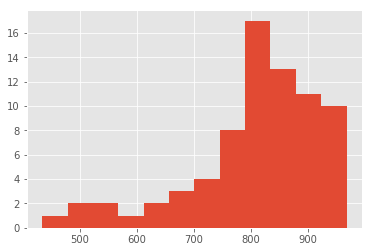

In [33]:
plt.hist(df_ausfallzeit, bins = 12)

In [29]:
weibull_model = pm.Model()

In [44]:
y = df_ausfallzeit.reset_index(drop=True).values

In [49]:
def weibull(x, alpha, beta):
    
    return -(x / beta)**alpha

In [59]:
with weibull_model:
    alpha_sd = 10.0

    mu = pm.Exponential('mu2', mu=0, sd=100)
    alpha_raw = pm.Exponential('a2', mu=0, sd=0.1)
    alpha = pm.Deterministic('alpha', tt.exp(alpha_sd * alpha_raw))
    beta = pm.Deterministic('beta', tt.exp(mu / alpha))

    y_obs = pm.Weibull('y_obs', alpha=alpha, beta=beta, observed=y)
    y_cens = pm.Potential('y_cens', weibull(y, alpha, beta))

ValueError: Variable name mu2 already exists.

In [55]:
with weibull_model:
    # Increase tune and change init to avoid divergences
    trace_1 = pm.sample(draws=1000, tune=1000,
                        nuts_kwargs={'target_accept': 0.9},
                        init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


ValueError: Name of variable not unique: mu.

In [56]:
pm.traceplot(trace_1, varnames=['alpha', 'beta']);

NameError: name 'trace_1' is not defined

In [57]:
pm.summary(trace_1, varnames=['alpha', 'beta']).round(2)


NameError: name 'trace_1' is not defined